In [1]:
### RUN EVERY TIME: ECONOMIC INDICES RELEASES HISTORY EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
from datetime import date, datetime
from math import floor, ceil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gc

#%load_ext line_profiler

In [3]:
### VERSION CONTROL

from platform import python_version
print('pandas version: ', pd.__version__)
print('python version: ', python_version())

pandas version:  0.25.3
python version:  3.7.4


In [4]:
### RUN EVERY TIME: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable']
### Raw data path and sheets:
str_path_bb_idx_source = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.xlsx'
str_us_sheet = 'US Eco Const'
str_all_sheet = 'All Eco Const'
### Flags data path and sheets:
str_path_bb_idx_flags = 'Data_Files/Source_Files/Bloomberg_Eco_Flags_Extended.xlsx'
str_flag_sheet = 'Bloomberg Description'
### Global index diagonals collection:
str_path_bb_diag_hdf = 'Data_Files/Source_Files/Diag_Eco_Indices.h5'
str_key_diag_agg_z_lim = 'aggregated_diagonal_z_limited'
### PC FPC weights collection:
str_path_fpc_hdf = 'Data_Files/Source_Files/FPC_Weights.h5'
str_weights_key = 'global_diagonal_full_yoy' # 'global_diagonal_full_mom' # 
### Source data constants:
int_idx_cols = 12
### HDF file with converted source data:
str_path_bb_fcast_hdf = 'Data_Files/Source_Files/Bloomberg_Forecasts.h5' ### LINE TO ADD
str_key_flags = 'flags_exported' ### LINE TO ADD
str_key_exported = 'all_idx_exported' ### LINE TO ADD
str_key_raw_filled = 'all_idx_raw_filled' ### LINE TO ADD
str_key_cleared = 'all_idx_cleared' ### LINE TO ADD
str_key_weighted = 'all_idx_weighted' ### LINE TO ADD
str_key_surprise = 'surprise_factor' ### LINE TO ADD
str_key_disagreement = 'disagreement_factor' ### LINE TO ADD
str_key_surprise_simple = 'surprise_simple' ### LINE TO ADD
str_key_disagreement_simple = 'disagreement_simple' ### LINE TO ADD
### Observation axis range:
datetime_start = datetime(1984, 12, 31) # Start date for efficacy measures
date_start = datetime_start.date()
datetime_end = datetime(2020, 8, 31) # End date for efficacy measures
date_end = datetime_end.date()
idx_date_range = pd.date_range(date_start, date_end, freq = 'B')
datetime_basis = datetime(1993, 12, 31) # End date for efficacy measures
date_basis = datetime_basis.date()
### Gaps filling options:
int_revision_shift = 1
int_final_shift = 2
int_first_mean_length = 12
dict_final_only_lag = {}
dict_final_only_lag['Quarterly'] = 90 // 2
dict_final_only_lag['Monthly'] = 30 // 2
dict_final_only_lag['Other'] = 7 // 2
### Z-scoring options:
int_winsorize_bound = 4
flo_winsorize_tolerance = 0.0001
int_winsorize_steps_limit = 5
### Regions weights:
dict_region_weight = {}
dict_region_weight['US'] = 0.50
dict_region_weight['Europe'] = 0.25
dict_region_weight['Japan'] = 0.15
dict_region_weight['UK'] = 0.10
### Business year length:
int_bus_year = 260
### NBER Source file:
str_path_nber_source = 'Data_Files/Source_Files/NBER_Chronology.xlsx'
### NBER Recession periods collection:
str_path_nber_hdf = 'Data_Files/Source_Files/NBER_Chronology.h5'
str_nber_periods_key = 'nber_recession_periods'
### CFNAI Source file:
str_path_cfnai_source = 'Data_Files/Source_Files/CFNAI.xlsx'
### CFNAI data collection:
str_path_cfnai_hdf = 'Data_Files/Source_Files/CFNAI.h5'
str_cfnai_full_key = 'cfnai_all_indices'
### MSCI World Index Source file:
str_path_msci_source = 'Data_Files/Source_Files/MSCI_World_Index.xlsx'
### MSCI World Index data collection:
str_path_msci_hdf = 'Data_Files/Source_Files/MSCI_World_Index.h5'
str_msci_world_key = 'msci_world'
str_msci_market_down_key = 'msci_recession_periods'
### Economic Surprise & Survey Disagreement options:
list_smooth = [1, 12] ### LINE TO ADD
list_clip = [-4.0, 4.0] ### LINE TO ADD
int_min_tickers_to_go = 5 ### LINE TO ADD
int_obs_num_win = 1 * int_bus_year ### LINE TO ADD
int_disagreement_max = 5 * int_bus_year ### LINE TO ADD
int_disagreement_min = 1 * int_bus_year ### LINE TO ADD
int_bus_month = 22 ### LINE TO ADD
int_bus_min = 1 ### LINE TO ADD

In [5]:
### DEFINING OBSERVATION DATE VECTOR EXTRACTION

def get_obs_date_vector(str_ticker, str_date, bool_exact_date = False, bool_drop_levels = False):
    ### Vector for exact date:
    if bool_exact_date:
        ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
    ### Vector for nearest date:        
    else:
        ### Loading full ticker series:        
        ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
        ### Extracting data for max date less or equal to needed date:
        ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
    ### Dropping constant index levels if needed:
    if bool_drop_levels:
        return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
    else:
        return ser_obs_date

In [6]:
### DEFINING WEIGHTED AVERAGE FOR DATAFRAME COLUMNS (PART OF THE PRODUCT CODE)

def columns_average(df_series, list_weights = False): 
    ### Single column check
    if (len(df_series.columns) > 1):
        ### Equal weights list creating:
        if isinstance(list_weights, bool):
            list_weights = [1] * len(df_series.columns)
        ### Dataframe of weights initialising:
        df_weights = pd.DataFrame(np.NaN, index = df_series.index, columns = df_series.columns)
        for iter_num, iter_col in enumerate(df_weights.columns):
            df_weights[iter_col] = list_weights[iter_num]
        ### Zeroing weights for NaN values:
        for iter_col in df_weights.columns:
            df_weights.loc[df_series[iter_col].isna(), iter_col] = 0
        ser_mean = (df_series.multiply(df_weights).sum(axis = 1)).div(df_weights.sum(axis = 1))    
        ### Results output:
        del df_series
        del df_weights    
        gc.collect()
    else:
        ser_mean = df_series.squeeze()
        del df_series
        gc.collect()        
    return ser_mean

In [ ]:
### RUN TO RE-EXPORT DATA: SOURCE FILE EXPORT

### Reading excel file:
df_all_idx_raw = pd.read_excel(engine = 'openpyxl', io = str_path_bb_idx_source, sheet_name = str_all_sheet, skiprows = [0], index_col = None, header = None, 
                               parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### List of dataframes for each eco index initializing:
list_idx_raw = []
### Extracting and converting each eco index data block separately to proper form:
for int_iter_idx_col in range(len(df_all_idx_raw.columns) // int_idx_cols):
    ### Extracting raw data:
    df_iter_idx_raw = df_all_idx_raw.iloc[All, (int_iter_idx_col * int_idx_cols) : ((int_iter_idx_col + 1) * int_idx_cols) - 1]
    ### Assigning colum names:
    df_iter_idx_raw.columns = df_iter_idx_raw.iloc[1]
    df_iter_idx_raw.columns.name = ''    
    ### Dropping empty rows:
    df_iter_idx_raw.dropna(how = 'all', inplace = True)
    ### Extracting eco index name:
    df_iter_idx_raw['Index_Name'] = df_iter_idx_raw.iloc[0, 0]
    ### Dropping identification rows (no longer needed):
    df_iter_idx_raw.drop([0, 1], axis = 0, inplace = True)
    ### Setting multiindex:
    df_iter_idx_raw.set_index(['Date', 'Index_Name'], drop = True, append = False, inplace = True)
    ### ADding dataframe to list:
    list_idx_raw.append(df_iter_idx_raw)
### Exported data aggregating:
df_all_idx_exported = pd.concat(list_idx_raw, axis = 0).swaplevel()
### Exported data saving:
df_all_idx_exported.index.names = ['Index_Name', 'Data_Date']
### Types converting for numerical data:
df_all_idx_exported = df_all_idx_exported.astype({'PX_LAST': 'float',
                                                  'ACTUAL_RELEASE': 'float',
                                                  'FIRST_REVISION': 'float',
                                                  'BN_SURVEY_NUMBER_OBSERVATIONS': 'float',
                                                  'BN_SURVEY_MEDIAN': 'float',
                                                  'BN_SURVEY_AVERAGE': 'float',
                                                  'FORECAST_STANDARD_DEVIATION': 'float',
                                                 })
### Zero dates dropping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] == 0, ['ECO_RELEASE_DT']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] == 0, ['FIRST_REVISION_DATE']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] == 0, ['ECO_FUTURE_RELEASE_DATE']] = np.NaN
### Incorrect dates droppping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] > 20210000, 'ECO_RELEASE_DT'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] > 20210000, 'FIRST_REVISION_DATE'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] > 20210000, 'ECO_FUTURE_RELEASE_DATE'] = np.NaN
### Dates formatting:
df_all_idx_exported['ECO_RELEASE_DT'] = pd.to_datetime(df_all_idx_exported['ECO_RELEASE_DT'].astype(str), format = '%Y%m%d')
df_all_idx_exported['FIRST_REVISION_DATE'] = pd.to_datetime(df_all_idx_exported['FIRST_REVISION_DATE'].astype(str), format = '%Y%m%d')
df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] = pd.to_datetime(df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'].astype(str), format = '%Y%m%d')
### Exported dataframe saving:
df_all_idx_exported.to_hdf(str_path_bb_fcast_hdf, key = str_key_exported, mode = 'w')

In [ ]:
### RUN TO RE-EXPORT DATA: FLAGS FILE EXPORT

### Reading excel file:
df_flags = pd.read_excel(engine = 'openpyxl', io = str_path_bb_idx_flags, sheet_name = str_flag_sheet, usecols = list(range(38))[1: ], index_col = 0, 
                         skiprows = list(range(6)), header = 0, parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_flags.dropna(how = 'all', inplace = True)
df_flags.index.name = 'Index_Name'
### Choosing columns to go on with:
df_flags = \
        df_flags[['CTRY', 'Type', 'Category', 'Negative', 'Security Description', 'SA/NSA', 'Processing', 'Index: Base', 'Type 2', 'INDX_SOURCE', 'DES_NOTES', 'INDX_FREQ']]
### Columns renaming:
df_flags.columns = ['Region', 'Type_Prime', 'Category', 'Negative', 'Description', 'SA_Status', 'Processing', 'Base', 'Type_Second', 'Data_Source', 'Notes', 'Frequency']
### Seasonality Adjustment Flag filling:
df_flags['SA_Status'] = df_flags['SA_Status'].fillna('Unclear')
### Processing Index separating:
df_flags['Processing'] = df_flags['Processing'].str.partition(': ')[0].str.strip()
### Base filling:
df_flags['Base'] = df_flags['Base'].fillna(-1)
### Euro countries region renaming:
df_flags.loc[~df_flags['Region'].isin(['Japan', 'UK', 'US']), 'Region'] = 'Europe'
### Columns reordering:
df_flags = df_flags[['Type_Prime', 'Type_Second', 'Category', 'Region', 'Processing', 'Base', 'SA_Status', 'Frequency', 'Negative', 'Description', 'Data_Source', 'Notes']]
### Types converting:
df_flags = df_flags.astype({'Type_Prime': 'str',
                            'Type_Second': 'str',
                            'Category': 'str',
                            'Region': 'str',
                            'Processing': 'str',
                            'Base': 'int',
                            'SA_Status': 'str',
                            'Frequency': 'str',
                            'Negative': 'int',
                            'Description': 'str',
                            'Data_Source': 'str',
                            'Notes': 'str'})
### Sub Type info adding:
df_flags['Sub_Type'] = df_flags['Type_Second']
df_flags.loc[(df_flags['Type_Prime'] == 'INF') & (df_flags['Type_Second'].isin(['CPI', 'ICP', 'RPI'])), 'Sub_Type'] = 'CPI' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'OUT') & (df_flags['Type_Second'].isin(['IndSales', 'Prod'])), 'Sub_Type'] = 'Prod' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'CON') & (df_flags['Type_Second'].isin(['Cons', 'Sales'])), 'Sub_Type'] = 'Cons' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'ANT') & (df_flags['Type_Second'].isin(['Bus', 'PMI'])), 'Sub_Type'] = 'Bus' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'ANT'), 'Category'] = 'Leading' ### NEW LINE
### Exported dataframe saving:
df_flags.to_hdf(str_path_bb_fcast_hdf, key = str_key_flags, mode = 'a')

In [ ]:
### RUN TO RE-EXPORT DATA: RELEASES AND REVISIONS DATA EXTRACTING

### Revisions data reading (99,180 rows):
df_all_idx_revisions = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_exported)[
                       ['PX_LAST', 'ECO_RELEASE_DT', 'ACTUAL_RELEASE', 'FIRST_REVISION_DATE', 'FIRST_REVISION', 'ECO_FUTURE_RELEASE_DATE', 
                        'BN_SURVEY_NUMBER_OBSERVATIONS', 'BN_SURVEY_MEDIAN', 'BN_SURVEY_AVERAGE', 'FORECAST_STANDARD_DEVIATION']] ### LINE TO MODIFY
### Dropping rows with all Index Values missed (96,369 rows left):
#df_all_idx_revisions = \
#        df_all_idx_revisions.loc[df_all_idx_revisions['PX_LAST'].notna() | df_all_idx_revisions['ACTUAL_RELEASE'].notna() | df_all_idx_revisions['FIRST_REVISION'].notna()]
### Date filtering:
df_all_idx_revisions = df_all_idx_revisions.reset_index('Data_Date')
df_all_idx_revisions = df_all_idx_revisions.loc[df_all_idx_revisions['Data_Date'] >= datetime_start].set_index('Data_Date', append = True)
### Columns renaming:
df_all_idx_revisions.columns = ['Final_Value', 'Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Future_Date', 
                                'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std'] ### LINE TO MODIFY

In [ ]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING

### 1 : MPMIITMA Index Revision_Value mistake correction:
df_all_idx_revisions.loc[('MPMIITMA Index', All), 'Revision_Value'] = np.NaN
### 2 : JNCPT Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCPT Index', '1999-07-31'), 'Release_Date'] = pd.to_datetime('1999-07-30')
df_all_idx_revisions.loc[('JNCPT Index', '2001-01-31'), 'Release_Date'] = pd.to_datetime('2001-01-26')
df_all_idx_revisions.loc[('JNCPT Index', '2001-02-28'), 'Release_Date'] = pd.to_datetime('2001-03-02')
df_all_idx_revisions.loc[('JNCPT Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-06-29')
### 3 : JNCSTOTY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCSTOTY Index', '2018-12-31'), 'Release_Date'] = pd.to_datetime('2019-01-31')
### 4: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNPIY Index', '2015-12-31'), 'Revision_Date'] = pd.to_datetime('2016-02-23')
### 5: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNTIAIAM Index', '2017-11-30'), 'Revision_Date'] = pd.to_datetime('2018-02-20')
### 6: BECPCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BECPCHNG Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-01-30')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-10-28')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-11-29')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-12-31'), 'Release_Date'] = pd.to_datetime('2001-12-23')
### 7 : BEUER Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BEUER Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-02-06')
### 8 : FRCPEECM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPEECM Index', '1997-07-31'), 'Release_Date'] = pd.to_datetime('1997-08-14')
### 9 : FRCPIMOM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-02-28'), 'Release_Date'] = pd.to_datetime('1999-03-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-02-21')
### 10 : GKCPNEWY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-03-31'), 'Release_Date'] = pd.to_datetime('2001-04-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-04-30'), 'Release_Date'] = pd.to_datetime('2001-05-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-05-31'), 'Release_Date'] = pd.to_datetime('2001-06-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-07-05')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-07-31'), 'Release_Date'] = pd.to_datetime('2001-08-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-08-31'), 'Release_Date'] = pd.to_datetime('2001-09-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-09-30'), 'Release_Date'] = pd.to_datetime('2001-10-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-11-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-12-09')
### 11 : GKUERATE Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKUERATE Index', '2007-01-31'), 'Release_Date'] = np.NaN
### 12 : GRCP2NRM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2NRM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 13 : GRCP2SAM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2SAM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 14 : ITVHYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('ITVHYOY Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-03')
### 15 : JNLSUCTL Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNLSUCTL Index', '2003-01-31'), 'Release_Date'] = pd.to_datetime('2003-03-01')
### 16 : PTCIEC Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('PTCIEC Index', '2007-12-31'), 'Release_Date'] = pd.to_datetime('2008-01-08')
### 17 : SLCPLHMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SLCPLHMM Index', '2004-04-30'), 'Release_Date'] = pd.to_datetime('2004-05-20')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-01-31'), 'Release_Date'] = pd.to_datetime('2005-02-27')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-02-28'), 'Release_Date'] = pd.to_datetime('2005-03-16')
### 18 : SPCPEUMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-01-31'), 'Release_Date'] = pd.to_datetime('2000-02-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-02-29'), 'Release_Date'] = pd.to_datetime('2000-03-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-03-31'), 'Release_Date'] = pd.to_datetime('2000-04-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-04-30'), 'Release_Date'] = pd.to_datetime('2000-05-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-05-31'), 'Release_Date'] = pd.to_datetime('2000-06-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-06-30'), 'Release_Date'] = pd.to_datetime('2000-07-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-07-31'), 'Release_Date'] = pd.to_datetime('2000-08-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-08-31'), 'Release_Date'] = pd.to_datetime('2000-09-13')
### 19 : SPROCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPROCHNG Index', '2008-01-31'), 'Release_Date'] = pd.to_datetime('2008-02-25')
### 20 : SVAWRYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-08-31'), 'Release_Date'] = pd.to_datetime('2006-10-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-09-30'), 'Release_Date'] = pd.to_datetime('2006-11-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-10-31'), 'Release_Date'] = pd.to_datetime('2006-12-17')
### 21 : INJCJC Index Data Date shifts correction:
df_all_idx_revisions.loc[('INJCJC Index', '2020-08-28'), 'Release_Date'] = np.NaN
str_ei_to_correct = 'INJCJC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_to_correct = df_ei_to_correct.drop(df_ei_to_correct.loc[df_ei_to_correct.isna().all(axis = 1)].index)
df_ei_to_correct_shifted = df_ei_to_correct.shift(-1)
df_ei_to_correct_shifted.columns = [str_column_name + '_shifted' for str_column_name in df_ei_to_correct_shifted.columns] 
df_ei_corrected = pd.concat([df_ei_to_correct, df_ei_to_correct_shifted], axis = 1)
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Date'] = \
                df_ei_corrected['Revision_Date_shifted']
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Value'] = \
                df_ei_corrected['Revision_Value_shifted']
df_ei_corrected = df_ei_corrected[df_ei_to_correct.columns]
df_ei_corrected = df_ei_corrected.drop(df_ei_corrected[df_ei_corrected['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 22 : INJCSP Index Data Date shifts correction:
str_ei_to_correct = 'INJCSP Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 23 : ITSR1B Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('ITSR1B Index', '1992-12-31'))
### 24 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'ATIPIMM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2004-04-30')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 25 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'GKIPIYOY Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 26 : IEIPIMOM Index partly dropping due to the gap:
str_ei_to_correct = 'IEIPIMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 27 : ITNHMOM Index partly dropping due to the gap:
str_ei_to_correct = 'ITNHMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-03-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 28 : MPMIGBXA Index partly dropping due to the gap:
str_ei_to_correct = 'MPMIGBXA Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2005-07-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 29 : PCE CHNC Index partly dropping due to the gap:
str_ei_to_correct = 'PCE CHNC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 30 : PTPPMOM Index partly dropping due to the gap:
str_ei_to_correct = 'PTPPMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 31 : SNTEEUGX Index partly dropping due to the gap:
str_ei_to_correct = 'SNTEEUGX Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 32 : UKISCTMM Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('UKISCTMM Index', '1992-12-31'))
### 33 : IERSVMOM Index adding missed rows:
str_ei_to_correct = 'IERSVMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-01-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-02-28')), All] = np.NaN
### 34 : ITNHMOM Index adding missed rows:
str_ei_to_correct = 'ITNHMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-08-31')), All] = np.NaN
### 35 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'NEISIYOY Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-11-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2002-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2003-07-31')), All] = np.NaN
### 36 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'MAPMINDX Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-05-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-06-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-09-30')), All] = np.NaN
### 37 : COMFCOMF Index values correcting:
str_ei_to_correct = 'COMFCOMF Index'
df_ei_to_correct = df_all_idx_revisions.copy().loc[(str_ei_to_correct, All), All]
df_ei_to_correct.loc[df_ei_to_correct['Release_Value'] < 10, 'Release_Value'] = (1 + df_ei_to_correct['Release_Value'] / 100) * 50
df_ei_to_correct.loc[df_ei_to_correct['Revision_Value'] < 10, 'Revision_Value'] = (1 + df_ei_to_correct['Revision_Value'] / 100) * 50
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_to_correct], axis = 0).sort_index()

In [ ]:
### RUN TO RE-EXPORT DATA: EXTRACTING RELEASE AND FIRST REVISION DATE/VALUE PAIRS:

### Release data extracting:
df_release_based = df_all_idx_revisions[['Release_Date', 'Release_Value']]
df_release_based.columns = ['Observation_Date', 'Index_Value']
### All empty release date vector Eco Indices:
ser_empty_release_date = df_release_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_release_date = ser_empty_release_date[ser_empty_release_date == 0]
### All empty release value vector Eco Indices:
ser_empty_release_value = df_release_based['Index_Value'].groupby('Index_Name').count()
ser_empty_release_value = ser_empty_release_value[ser_empty_release_value == 0]
### All empty release date or all empty release value indices list:
list_empty_release = sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index))))
### Revision data extracting:
df_revision_based = df_all_idx_revisions[['Revision_Date', 'Revision_Value']]
df_revision_based.columns = ['Observation_Date', 'Index_Value']
### All empty first revision date vector Eco Indices:
ser_empty_revision_date = df_revision_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_revision_date = ser_empty_revision_date[ser_empty_revision_date == 0]
### All empty first revision value vector Eco Indices:
ser_empty_revision_value = df_revision_based['Index_Value'].groupby('Index_Name').count()
ser_empty_revision_value = ser_empty_revision_value[ser_empty_revision_value == 0]
### All empty first revision date or all empty first revision value indices list:
list_empty_revision = sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index))))

In [ ]:
### RUN TO RE-EXPORT DATA: ALL DATES FILLING PROCEDURE

df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)

#### Dates filling:
def all_dates_filler(df_eco_ind):
    ### Eco Indice options saving:
    str_index_name = df_eco_ind.index.get_level_values(0)[0]
    str_eco_ind_freq = df_flags.loc[str_index_name, 'Frequency']
    if (str_eco_ind_freq in dict_final_only_lag.keys()):
        int_final_only_lag = dict_final_only_lag[str_eco_ind_freq]
    else:
        int_final_only_lag = dict_final_only_lag['Other']
    ### Index_Name level dropping:
    df_eco_ind = df_eco_ind.droplevel(0)
    ### Index duplicating to column:
    df_eco_ind['Event_Date'] = df_eco_ind.index
    df_eco_ind['Release_Lag'] = np.NaN
    ### No release checking:
    if (str_index_name in list_empty_release): 
        df_eco_ind['Final_Date'] = df_eco_ind['Event_Date'] + pd.Timedelta(int_final_only_lag, 'D')
    elif (str_index_name in list_empty_revision):    
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]        
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date by lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)   
    else:
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]     
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1        
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date with lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Filling empty revision dates: 
        df_eco_ind.loc[df_eco_ind['Revision_Date'].isna(), 'Revision_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_final_shift)
    ### Last values having revision date with no revision value managing:
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Revision_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having release date with no release value managing:
    idx_last_values = df_eco_ind['Release_Date'].notna() & df_eco_ind['Release_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Release_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and future date managing (no news detected):
    idx_last_values = df_eco_ind['Future_Date'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and having revision pair managing (no news detected):
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].notna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and no revision pair managing:
    idx_last_values = df_eco_ind['Revision_Date'].isna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Date'] = df_eco_ind['Future_Date']    
    ### Results ouput:
    return df_eco_ind[['Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Final_Date', 'Final_Value', 
                       'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std']] ### LINE TO MODIFY
### Date filling for each eco index performing:
df_dates_filled = df_all_idx_revisions.groupby('Index_Name').apply(all_dates_filler)

In [ ]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING ### CELL TO ADD

### 124 : BEBCI Index early Survey_Median values clearing:
df_dates_filled.loc[('BEBCI Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2002, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 125 : BECPCHNG Index all Survey data clearing:
df_dates_filled.loc[('BECPCHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 126 : COMFCOMF Index all Survey data clearing:
df_dates_filled.loc[('COMFCOMF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 127 : ESCPLMOM Index all Survey data clearing:
df_dates_filled.loc[('ESCPLMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 128 : EUBCI Index Survey Error clearing:
df_dates_filled.loc[('EUBCI Index', '2010-12-31'), ['Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 129 : FIBCIND Index all Survey data clearing:
df_dates_filled.loc[('FIBCIND Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 130 : FICCI Index all Survey data clearing:
df_dates_filled.loc[('FICCI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 131 : FIIPSAIM Index all Survey data clearing:
df_dates_filled.loc[('FIIPSAIM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 132 : FIPPIR2M Index all Survey data clearing:
df_dates_filled.loc[('FIPPIR2M Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 133 : FIRSVYOY Index all Survey data clearing:
df_dates_filled.loc[('FIRSVYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 134 : FIUER Index all Survey data clearing:
df_dates_filled.loc[('FIUER Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 135 : FRCPIMOM Index Survey Error clearing:
df_dates_filled.loc[('FRCPIMOM Index', '2012-01-31'), ['Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 136 : FRJSTCHG Index all Survey data clearing:
df_dates_filled.loc[('FRJSTCHG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 137 : FRPIMOM Index all Survey data clearing:
df_dates_filled.loc[('FRPIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 138 : GKCPIUHY Index all Survey data clearing:
df_dates_filled.loc[('GKCPNEWY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 139 : GKCPIUHY Index all Survey data clearing:
df_dates_filled.loc[('GKCPNEWY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 140 : GKIPIYOY Index all Survey data clearing:
df_dates_filled.loc[('GKIPIYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 141 : GKRSNEWY Index all Survey data clearing:
df_dates_filled.loc[('GKRSNEWY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 142 : GKUERATE Index all Survey data clearing:
df_dates_filled.loc[('GKUERATE Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 143 : GRCP2NRM Index all Survey data clearing:
df_dates_filled.loc[('GRCP2NRM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 144 : GRWPMOMI Index all Survey data clearing:
df_dates_filled.loc[('GRWPMOMI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 145 : GRZEEUEX Index all Survey data clearing:
df_dates_filled.loc[('GRZEEUEX Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 146 : IECPEUIQ Index all Survey data clearing:
df_dates_filled.loc[('IECPEUIQ Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 147 : IECPIMOM Index all Survey data clearing:
df_dates_filled.loc[('IECPIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 148 : IEIPIMOM Index all Survey data clearing:
df_dates_filled.loc[('IEIPIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 149 : IEPPIEUM Index all Survey data clearing:
df_dates_filled.loc[('IEPPIEUM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 150 : IERSVMOM Index all Survey data clearing:
df_dates_filled.loc[('IERSVMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 151 : IEUELV Index all Survey data clearing:
df_dates_filled.loc[('IEUELV Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 152 : IEUEMOM Index all Survey data clearing:
df_dates_filled.loc[('IEUEMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 153 : IEUERT Index all Survey data clearing:
df_dates_filled.loc[('IEUERT Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 154 : ITISTSAM Index all Survey data clearing:
df_dates_filled.loc[('ITISTSAM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 155 : ITNHMOM Index all Survey data clearing:
df_dates_filled.loc[('ITNHMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 156 : ITORTSAM Index all Survey data clearing:
df_dates_filled.loc[('ITORTSAM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 157 : ITPNIMOM Index all Survey data clearing:
df_dates_filled.loc[('ITPNIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 158 : ITVHYOY Index all Survey data clearing:
df_dates_filled.loc[('ITVHYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 159 : JCOMACF Index all Survey data clearing:
df_dates_filled.loc[('JCOMACF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 160 : JCOMHCF Index all Survey data clearing:
df_dates_filled.loc[('JCOMHCF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 161 : JCPNEFEY Index all Survey data clearing:
df_dates_filled.loc[('JCPNEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 162 : JCPTEFEY Index all Survey data clearing:
df_dates_filled.loc[('JCPTEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 163 : JNCAP Index all Survey data clearing:
df_dates_filled.loc[('JNCAP Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 164 : JNCPT Index early Survey_Median values clearing:
df_dates_filled.loc[('JNCPT Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2001, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 165 : JNCSTOTY Index all Survey data clearing:
df_dates_filled.loc[('JNCSTOTY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 166 : JNCVSSY Index all Survey data clearing:
df_dates_filled.loc[('JNCVSSY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 167 : JNDSNYOY Index all Survey data clearing:
df_dates_filled.loc[('JNDSNYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 168 : JNMTOY Index all Survey data clearing:
df_dates_filled.loc[('JNMTOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 169 : JNPIY Index early Survey_Median values clearing:
df_dates_filled.loc[('JNPIY Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2001, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 170 : JNSBALLI Index all Survey data clearing:
df_dates_filled.loc[('JNSBALLI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 171 : JNVHPYOY Index all Survey data clearing:
df_dates_filled.loc[('JNVHPYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 172 : JNVHSYOY Index all Survey data clearing:
df_dates_filled.loc[('JNVHSYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 173 : JWCOOVRL Index all Survey data clearing:
df_dates_filled.loc[('JWCOOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 174 : JWEXOVRL Index all Survey data clearing:
df_dates_filled.loc[('JWEXOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 175 : MAPMINDX Index all Survey data clearing:
df_dates_filled.loc[('MAPMINDX Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 176 : NECCISA Index all Survey data clearing:
df_dates_filled.loc[('NECCISA Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 177 : NEIP20MM Index all Survey data clearing:
df_dates_filled.loc[('NEIP20MM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 178 : NEPRI Index all Survey data clearing:
df_dates_filled.loc[('NEPRI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 179 : NERS20Y Index all Survey data clearing:
df_dates_filled.loc[('NERS20Y Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 180 : PLCPMOM Index all Survey data clearing:
df_dates_filled.loc[('PLCPMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 181 : PPI CHNG Index all Survey data clearing:
df_dates_filled.loc[('PPI CHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 182 : PTCPHAMM Index all Survey data clearing:
df_dates_filled.loc[('PTCPHAMM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 183 : PTIPTOTM Index all Survey data clearing:
df_dates_filled.loc[('PTIPTOTM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 184 : PXFECHNG Index all Survey data clearing:
df_dates_filled.loc[('PXFECHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 185 : SAARDTOT Index all Survey data clearing:
df_dates_filled.loc[('SAARDTOT Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 186 : SKCCCONC Index all Survey data clearing:
df_dates_filled.loc[('SKCCCONC Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 187 : SKCCINDC Index all Survey data clearing:
df_dates_filled.loc[('SKCCINDC Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 188 : SLCPLHMM Index all Survey data clearing:
df_dates_filled.loc[('SLCPLHMM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 189 : SLIPTIYY Index all Survey data clearing:
df_dates_filled.loc[('SLIPTIYY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 190 : SLPPIPMM Index all Survey data clearing:
df_dates_filled.loc[('SLPPIPMM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 191 : SLPRYOYA Index all Survey data clearing:
df_dates_filled.loc[('SLPRYOYA Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 192 : SLRTTXAY Index all Survey data clearing:
df_dates_filled.loc[('SLRTTXAY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 193 : SLWIIYOY Index all Survey data clearing:
df_dates_filled.loc[('SLWIIYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 194 : SPIOWAYY Index all Survey data clearing:
df_dates_filled.loc[('SPIOWAYY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 195 : SPIOYOY Index all Survey data clearing:
df_dates_filled.loc[('SPIOYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 196 : SPIPCCMM Index early Survey_Median values clearing:
df_dates_filled.loc[('SPIPCCMM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2004, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 197 : SPROCHNG Index all Survey data clearing:
df_dates_filled.loc[('SPROCHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 198 : SPRSRAY Index all Survey data clearing:
df_dates_filled.loc[('SPRSRAY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 199 : SPRSRGIY Index all Survey data clearing:
df_dates_filled.loc[('SPRSRGIY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 200 : SVCPMOM Index all Survey data clearing:
df_dates_filled.loc[('SVCPMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 201 : UKUEMOM Index all Survey data clearing:
df_dates_filled.loc[('UKUEMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 202 : UKUER Index all Survey data clearing:
df_dates_filled.loc[('UKUER Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN

In [ ]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING (COMPATIBILITY WITH RELEASES CORRECTION) ### CELL TO ADD

### 203 : PITLCHNG Index outlier values clipping:
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Median'] < -2), 'Survey_Median'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Median'] > 2), 'Survey_Median'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Average'] < -2), 'Survey_Average'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Average'] > 2), 'Survey_Average'] = 2.0
### 204 : GRIFPBUS Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift
### 205 : GRIFPCA Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift
### 206 : JNCICCOI Index releases/revisions clearing:
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2020-01-01'), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = np.NaN

In [ ]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING AND SAVING

### 38 : GKCPIUHY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPIUHY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-17')
df_dates_filled.loc[('GKCPIUHY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-17')
### 39 : GKCPNEWY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPNEWY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-10')
df_dates_filled.loc[('GKCPNEWY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-10')
### 40 : EUCPTSAM Index Final Date shifts correction: 
df_dates_filled.loc[('EUCPTSAM Index', '2004-12-31'), 'Final_Date'] = pd.to_datetime('2005-09-12')
df_dates_filled.loc[('EUCPTSAM Index', '2005-03-31'), 'Final_Date'] = pd.to_datetime('2005-12-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-06-30'), 'Final_Date'] = pd.to_datetime('2006-03-10')
df_dates_filled.loc[('EUCPTSAM Index', '2005-09-30'), 'Final_Date'] = pd.to_datetime('2006-06-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-12-31'), 'Final_Date'] = pd.to_datetime('2006-09-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-03-31'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-06-30'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-09-30'), 'Final_Date'] = pd.to_datetime('2007-01-18')
### 41 : SVUER Index Revision Date shifts correction: 
df_dates_filled.loc[('SVUER Index', '2005-06-30'), 'Revision_Date'] = pd.to_datetime('2005-09-18')
### 42 : UKMPIMOM Index Revision Date shifts correction: 
df_dates_filled.loc[('UKMPIMOM Index', '2001-01-31'), 'Revision_Date'] = pd.to_datetime('2001-04-09')
df_dates_filled.loc[('UKMPIMOM Index', '2001-02-28'), 'Revision_Date'] = pd.to_datetime('2001-05-08')
df_dates_filled.loc[('UKMPIMOM Index', '2001-03-31'), 'Revision_Date'] = pd.to_datetime('2001-06-11')
df_dates_filled.loc[('UKMPIMOM Index', '2001-04-30'), 'Revision_Date'] = pd.to_datetime('2001-07-10')
df_dates_filled.loc[('UKMPIMOM Index', '2001-05-31'), 'Revision_Date'] = pd.to_datetime('2001-08-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-08-31'), 'Revision_Date'] = pd.to_datetime('2001-11-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-10-31'), 'Revision_Date'] = pd.to_datetime('2002-01-14')
### 43 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESCPLMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1994, 1, 1)), All] = np.NaN
### 44 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESPPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2003, 1, 1)), All] = np.NaN
### 45 : ESCPLMOM Index revisions clearing:
df_dates_filled.loc[('ESPPIMOM Index', All), 'Revision_Value'] = np.NaN
### 46 : IECPIMOM Index early values clearing:
df_dates_filled.loc[('IECPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1998, 1, 1)), All] = np.NaN
### 47 : JBTARATE Index early values clearing:
df_dates_filled.loc[('JBTARATE Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1990, 1, 1)), All] = np.NaN
### 48 : SVBTSI Index early values clearing:
df_dates_filled.loc[('SVBTSI Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2005, 1, 1)), All] = np.NaN
### 49 : SVIPTMOM Index early values clearing:
df_dates_filled.loc[('SVIPTMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2008, 1, 1)), All] = np.NaN
### 50 : UKPPIINC Index early values clearing:
df_dates_filled.loc[('UKPPIINC Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 51 : UKPPXFBM Index early values clearing:
df_dates_filled.loc[('UKPPXFBM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 52 : GRCP2BRM Index outlier values clipping:
df_dates_filled.loc[('GRCP2BRM Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
### 53 : GRCP2SAM Index outlier values clipping:
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] < -5), 'Final_Value'] = -5.0
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] > 5), 'Final_Value'] = 5.0
### 54 : PITLCHNG Index outlier values clipping:
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] < -2), 'Release_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] > 2), 'Release_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] < -2), 'Revision_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] > 2), 'Revision_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] > 2), 'Final_Value'] = 2.0
### 55 : ITNSSTN Index outlier values clipping:
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Release_Value'] < -10), 'Release_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Release_Value'] > 10), 'Release_Value'] = 10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Revision_Value'] < -10), 'Revision_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Revision_Value'] > 10), 'Revision_Value'] = 10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Final_Value'] < -10), 'Final_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Final_Value'] > 10), 'Final_Value'] = 10.0
### 56 : EUNOEUM Index dropping:
df_dates_filled.drop(labels = 'ESRSREHY Index', level = 'Index_Name', inplace = True)
### 57 : EUNOEUM Index dropping:
df_dates_filled.drop(labels = 'EUNOEUM Index', level = 'Index_Name', inplace = True)
### 58 : NEUETOTR Index dropping:
df_dates_filled.drop(labels = 'NEUETOTR Index', level = 'Index_Name', inplace = True)
### 59 : RSSA25M Index dropping:
df_dates_filled.drop(labels = 'RSSA25M Index', level = 'Index_Name', inplace = True)
### 60 : UKISCTMM Index dropping:
df_dates_filled.drop(labels = 'UKISCTMM Index', level = 'Index_Name', inplace = True)
### 61 : UKMSVTVJ Index dropping:
df_dates_filled.drop(labels = 'UKMSVTVJ Index', level = 'Index_Name', inplace = True)
### 62 : UKNCCCIS Index dropping:
df_dates_filled.drop(labels = 'UKNCCCIS Index', level = 'Index_Name', inplace = True)
### 63 : FRQBMOP3 Index dropping (quarterly frequency):
df_dates_filled.drop(labels = 'FRQBMOP3 Index', level = 'Index_Name', inplace = True)
### 64 : UKBFFTIN Index dropping (quarterly frequency):
df_dates_filled.drop(labels = 'UKBFFTIN Index', level = 'Index_Name', inplace = True)
### 65 : JNSBALLI Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'JNSBALLI Index', level = 'Index_Name', inplace = True)
### 66 : SVUER Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'SVUER Index', level = 'Index_Name', inplace = True)
### 67 : FICCI Index dropping (dead since 2019):
df_dates_filled.drop(labels = 'FICCI Index', level = 'Index_Name', inplace = True)
### 68 : NECCISA Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'NECCISA Index', level = 'Index_Name', inplace = True)
### 69 : UKEGESTG Index dropping (dead since 2018):
df_dates_filled.drop(labels = 'UKEGESTG Index', level = 'Index_Name', inplace = True)
### 70 : SAARDTOT Index dropping (dead since 2018):
df_dates_filled.drop(labels = 'SAARDTOT Index', level = 'Index_Name', inplace = True)
### 71 : CPTICHNG Index finals clearing:
df_dates_filled.loc[('CPTICHNG Index', All), 'Final_Value'] = np.NaN
### 72 : ECO1GFKC Index finals clearing:
df_dates_filled.loc[('ECO1GFKC Index', All), 'Final_Value'] = np.NaN
### 73 : JNPIY Index finals clearing:
df_dates_filled.loc[('JNPIY Index', All), 'Final_Value'] = np.NaN
### 74 : PTCCI Index finals clearing:
df_dates_filled.loc[('PTCCI Index', All), 'Final_Value'] = np.NaN
### 75 : PTPPMOM Index finals clearing:
df_dates_filled.loc[('PTPPMOM Index', All), 'Final_Value'] = np.NaN
### 76 : UKUER Index finals clearing:
df_dates_filled.loc[('UKUER Index', All), 'Final_Value'] = np.NaN
### 77 : UMRTEMU Index finals clearing:
df_dates_filled.loc[('UMRTEMU Index', All), 'Final_Value'] = np.NaN
### 78 : GRIFPBUS Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift
### 79 : GRIFPCA Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift
### 80 : FRJSTCHG Index releases/revisions clearing:
df_dates_filled.loc[('FRJSTCHG Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 81 : JNCAP Index releases/revisions clearing:
df_dates_filled.loc[('JNCAP Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 82 : IEUERT Index releases/revisions clearing:
df_dates_filled.loc[('IEUERT Index', df_dates_filled.index.get_level_values('Data_Date') <= '2000-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### 83 : JNCICCOI Index releases/revisions clearing:
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2020-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### Empty Dates dropping:
df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna(), 'Release_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna(), 'Revision_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna(), 'Final_Date'] = np.NaN
### Moving early release dates to data dates:
df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date'], 'Release_Date'] = \
    df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date']].index.get_level_values('Data_Date')
### Moving early revision dates to data dates:
df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Revision_Date'] = \
    df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Release_Date']

In [ ]:
### RUN TO TESTING: CHECKING OF PAIR COMPLETENESS

print(df_dates_filled.loc[df_dates_filled['Final_Value'].notna() & df_dates_filled['Final_Date'].isna()])
print(df_dates_filled.loc[df_dates_filled['Final_Value'].isna() & df_dates_filled['Final_Date'].notna()])
print(df_dates_filled.loc[df_dates_filled['Release_Date'].isna() & df_dates_filled['Release_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna()])

In [ ]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING (FORECAST STD CHECKING) ### CELL TO ADD

#display(df_dates_filled[(abs(df_dates_filled['Forecast_Std']) > 50 * abs(df_dates_filled['Survey_Average'] - df_dates_filled['Release_Value'])) & 
#                        (abs(df_dates_filled['Survey_Average'] - df_dates_filled['Release_Value']) > 0.0001)])
#display(df_dates_filled[(abs(df_dates_filled['Forecast_Std']) > 50 * abs(df_dates_filled['Survey_Median'] - df_dates_filled['Release_Value'])) & 
#                        (abs(df_dates_filled['Survey_Median'] - df_dates_filled['Release_Value']) > 0.0001)])

### 206 : GRFRIAMM Index Forecast Std correction:
df_dates_filled.loc[('GRFRIAMM Index', '1996-12-31'), 'Forecast_Std'] = np.NaN

### Dataframe types control:
print(df_dates_filled.dtypes)
### Filled dates saving:
df_dates_filled.to_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled, mode = 'a')

In [ ]:
### RUN TO TESTING: FILLED ECO INDICES DATA PLOTTING TO VISUAL CONTROL ### CELL TO ADD

### Index choosing:
str_test_index = 'GKRSNEWY Index'
### Data loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
#### Flags printing:
print(df_flags.loc[str_test_index, All])
### Series creating:
if ((len(df_dates_filled.loc[(str_test_index, All), 'Survey_Median'].dropna()) == 0) & (len(df_dates_filled.loc[(str_test_index, All), 'Survey_Average'].dropna()) == 0)):
    print('NO SURVEY DATA HERE!')
df_eco_ind = df_dates_filled.loc[(str_test_index, All), All].droplevel(0)[['Survey_Median', 'Survey_Average', 'Release_Value', 'Revision_Value', 'Final_Value']]    
date_xlim_start = df_eco_ind.index.min()
date_xlim_finish = df_eco_ind.index.max()
#date_xlim_start = datetime(1984, 12, 31)
#date_xlim_finish = datetime(2020, 1, 31)
date_xlim_finish = datetime(2020, 8, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
ax_eco_ind = df_eco_ind[['Survey_Median', 'Survey_Average', 'Release_Value']].plot(figsize = (15, 5), title = str_test_index + ' survey stats', 
                style = ['r*', 'bd', 'c+'], markersize = 7.5, markeredgewidth = 1.5, 
                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
plt.show()
#ax_eco_ind = df_eco_ind.plot(figsize = (20, 5), title = str_test_index + ' revisions', 
#                style = ['r*', 'bd', 'c+', 'mx', 'k-'], markersize = 7.5, markeredgewidth = 1.5,                              
#                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
#ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
#ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
#plt.show() 

In [ ]:
### UNIQUE FORECAST CODE HERE AND AFTER ###

In [33]:
### RUN TO RE-EXPORT DATA: TICKERS FILTERING DUE TO TYPE AND SURVEY DATA QUALITY

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
#### 98 - 108 : Dropped to keep only one representative from country in the particular group:
#df_dates_filled.drop(['ITISTSAM Index', 'NEISIYOY Index', 'PTISTOTM Index', 'SLIPTIYY Index', 'SPIOWAYY Index', 'IERSVMOM Index', 'ITNSSTN Index', 'SPRSRAY Index',
#                      'IEUELV Index', 'IEUEMOM Index', 'SLWIIYOY Index'], level = 'Index_Name', inplace = True)
#### 109 - 123 : Dropped due to weak correlation with other particular group members:
#df_dates_filled.drop(['SKCCCONC Index', 'GRZEEUEX Index', 'IEIPIMOM Index', 'IEPPIEUM Index', 'MTEF4C Index', 'JNVHSYOY Index', 'JNBTCASE Index', 'JNLSUCTL Index',
#                      'HPIMMOM% Index', 'CICRTOT Index', 'PXFECHNG Index', 'UKMSB3PS Index', 'UKAWXTOM Index', 'ITNHMOM Index', 'SVAWRYOY Index'], 
#                     level = 'Index_Name', inplace = True)
### Types and region export:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
df_group_info = df_flags[['Type_Prime', 'Sub_Type', 'Region']].copy()
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
df_forecast_data = df_dates_filled.join(df_group_info, how = 'left')
### Dropping EI's having wrong Primary Types:
#df_forecast_data.drop(df_forecast_data[df_forecast_data['Type_Prime'].isin(['TAR', 'INF'])].index, inplace = True)
df_forecast_data = df_forecast_data[df_forecast_data['Type_Prime'] != 'TAR']
### Survey data stats:
print('Observations having Survey Median values:', round(df_forecast_data['Survey_Median'].count() / len(df_forecast_data.index), 4))
print('Observations having Survey Average values:', round(df_forecast_data['Survey_Average'].count() / len(df_forecast_data.index), 4))
print('Observations having neither Survey Median nor Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having both Survey Median & Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Median values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
### Dropping rows doesn't have enough data:
df_forecast_data = df_forecast_data[['Release_Date', 'Release_Value', 'Survey_Median', 'Forecast_Std', 'Observations_Number', 'Region', 'Type']]\
                                  .dropna(subset = ['Release_Date'])
### Dates arranging:
df_forecast_data['Release_Date'] = df_forecast_data['Release_Date'] + 0 * pd.offsets.BDay()
df_forecast_data = df_forecast_data[df_forecast_data['Release_Date'] <= datetime_end]
df_forecast_data = df_forecast_data.reset_index('Data_Date', drop = True).set_index('Release_Date', append = True).sort_index()
### Duplicated observations removal (2 * 14):
df_forecast_data = df_forecast_data[~df_forecast_data.index.duplicated(keep = 'last')]
### Wrong observation number rows marking:
print('Observations with incorrect forecasters number values (NaN, 0, 1, 2):', 
      round(len(df_forecast_data[df_forecast_data['Observations_Number'].isna() | df_forecast_data['Observations_Number'].isin([0, 1, 2])].index) / 
            len(df_forecast_data.index), 4))
df_forecast_data['Observations_Number'].replace({np.NaN: -1, 0: -1, 1: -1, 2: -1}, inplace = True)
print('Observations with incorrect forecasters number values having forecast std value:', 
      round(len(df_forecast_data[df_forecast_data['Forecast_Std'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
print('Observations with incorrect forecasters number values having survey median value:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
### Tickers data reindexation to common timeline:
df_reindexed = df_forecast_data.unstack('Index_Name').sort_index().ffill().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Clearing rows having incorrect data:
df_cleared = df_reindexed[df_reindexed['Observations_Number'] > -1].copy().dropna()
print('Economic indices left to forecast indices generation:', len(df_cleared.index.get_level_values('Index_Name').unique()))
### Cleared and reindexed table saving:
df_cleared.to_hdf(str_path_bb_fcast_hdf, key = str_key_cleared, mode = 'a')
_ = gc.collect()

Observations having Survey Median values: 0.366
Observations having Survey Average values: 0.3578
Observations having neither Survey Median nor Survey Average values: 0.6339
Observations having both Survey Median & Survey Average values: 0.3577
Observations having only Survey Median values: 0.0083
Observations having only Survey Average values: 0.0001
Observations with incorrect forecasters number values (NaN, 0, 1, 2): 0.442
Observations with incorrect forecasters number values having forecast std value: 0.0371
Observations with incorrect forecasters number values having survey median value: 0.017
Economic indices left to forecast indices generation: 124


In [ ]:
### RUN TO TESTING: REGION / TYPE PAIR DEFINED GROUPS VISUAL CONTROL

def forecast_group_demo(ser_group):   
    flo_ylim_max = ser_group.max()
    tup_ylim = (0, flo_ylim_max + abs(flo_ylim_max) / 10)
    df_group = ser_group.unstack('Index_Name')
    idx_group_range = pd.date_range(df_group.index.min(), df_group.index.max(), freq = 'B')
    df_group = df_group.reindex(idx_group_range)
    ax_group = df_group.plot(figsize = (20, 5), title = ': '.join(ser_group.name) + ' observations number ( ' + str(len(df_group.columns)) +  ' members )', 
                                         ylim = tup_ylim, x_compat = True, grid = True)
    ax_group.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
    ax_group.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))   
    ax_group.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax_group.yaxis.set_minor_locator(plt.MultipleLocator(1))
    plt.show()

### Forecast data loading:
df_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared)
### Group data plotting:
_ = df_cleared.groupby(['Type', 'Region'])['Observations_Number'].apply(forecast_group_demo)

<Figure size 1080x360 with 0 Axes>

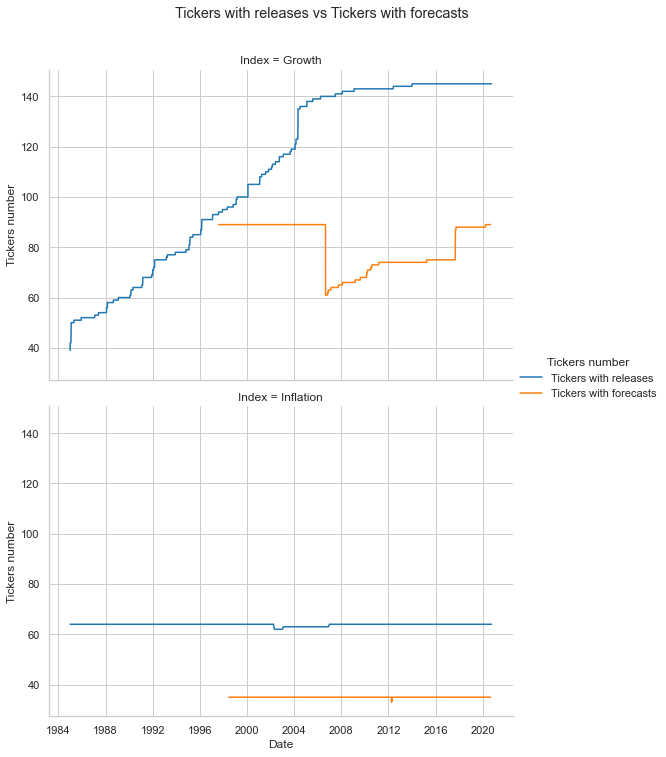

In [72]:
### RUN TO TESTING: TICKERS NUMBER V COMPARING

### EI Dataframe loading:
df_ei_data_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
ser_ei_data = df_ei_data_full['Release_Value'].notna() | df_ei_data_full['Revision_Value'].notna() | df_ei_data_full['Final_Value'].notna()
ser_ei_data.name = 'Value_Flag'
#### Dropped to keep only one representative from country in the particular group:
#ser_ei_data.drop(['ITISTSAM Index', 'NEISIYOY Index', 'PTISTOTM Index', 'SLIPTIYY Index', 'SPIOWAYY Index', 'IERSVMOM Index', 'ITNSSTN Index', 'SPRSRAY Index',
#                  'IEUELV Index', 'IEUEMOM Index', 'SLWIIYOY Index'], level = 'Index_Name', inplace = True)
#### Dropped due to weak correlation with other particular group members:
#ser_ei_data.drop(['SKCCCONC Index', 'GRZEEUEX Index', 'IEIPIMOM Index', 'IEPPIEUM Index', 'MTEF4C Index', 'JNVHSYOY Index', 'JNBTCASE Index', 'JNLSUCTL Index',
#                  'HPIMMOM% Index', 'CICRTOT Index', 'PXFECHNG Index', 'UKMSB3PS Index', 'UKAWXTOM Index', 'ITNHMOM Index', 'SVAWRYOY Index'], level = 'Index_Name', 
#                 inplace = True)
### Types and region export and clearing:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
df_group_info = df_flags.loc[df_flags['Type_Prime'] != 'TAR', ['Type_Prime', 'Sub_Type', 'Region']].copy()
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
df_ei_data_cleared = ser_ei_data.to_frame().join(df_group_info, how = 'left').dropna()
### Tickers number extraction:
dict_ei_number = {}
dict_ei_number['Growth'] = df_ei_data_cleared.loc[df_ei_data_cleared['Type_Prime'] != 'INF', 'Value_Flag'].unstack('Index_Name').ffill().count(axis = 1)
dict_ei_number['Inflation'] = df_ei_data_cleared.loc[df_ei_data_cleared['Type_Prime'] == 'INF', 'Value_Flag'].unstack('Index_Name').ffill().count(axis = 1)
### Forecasts Dataframe loading:
df_fcast_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared)
ser_fcast_data = df_fcast_cleared['Survey_Median'].notna() & df_fcast_cleared['Forecast_Std'].notna()
ser_fcast_data.name = 'Forecast_Flag'
### Types and region export and clearing:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
df_group_info = df_flags.loc[df_flags['Type_Prime'] != 'TAR', ['Type_Prime', 'Sub_Type', 'Region']].copy()
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
df_fcast_data = ser_fcast_data.to_frame().join(df_group_info, how = 'left').dropna()
### Tickers number extraction:
dict_fcast_number = {}
dict_fcast_number['Growth'] = df_fcast_data.loc[df_fcast_data['Type_Prime'] != 'INF', 'Forecast_Flag'].unstack('Index_Name').ffill().count(axis = 1)
dict_fcast_number['Inflation'] = df_fcast_data.loc[df_fcast_data['Type_Prime'] == 'INF', 'Forecast_Flag'].unstack('Index_Name').ffill().count(axis = 1)
### Plot creating:
ser_ei_number = pd.concat(dict_ei_number)
ser_ei_number.index.names = ['Index', 'Date']
ser_ei_number.name = 'Number'
ser_fcast_number = pd.concat(dict_fcast_number)
ser_fcast_number.index.names = ['Index', 'Date']
ser_fcast_number.name = 'Number'

df_to_plot = pd.concat([ser_ei_number, ser_fcast_number], axis = 0, keys = ['Tickers with releases', 'Tickers with forecasts'], names = ['Tickers number'])\
               .reset_index()
sns.set_style('whitegrid')
plt.figure(figsize = (15, 5))
sns.set_context('notebook')

fig_tickers_number = sns.relplot(data = df_to_plot, x = 'Date', y = 'Number', hue = 'Tickers number', row = 'Index', kind = 'line', aspect = 1.5)
fig_tickers_number.fig.suptitle('Tickers with releases vs Tickers with forecasts', y = 1.05)
fig_tickers_number.set_ylabels('Tickers number')
plt.show()

In [7]:
### RUN TO TESTING: GLOBAL INDICES REGION / TYPE STATS

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
### Tickers register extracting:
ser_ei_data = df_dates_filled.groupby('Index_Name', group_keys = False).apply(lambda df_group: df_group[: 1].droplevel('Data_Date'))['Observations_Number']
#### 98 - 108 : Dropped to keep only one representative from country in the particular group:
#ser_ei_data.drop(['ITISTSAM Index', 'NEISIYOY Index', 'PTISTOTM Index', 'SLIPTIYY Index', 'SPIOWAYY Index', 'IERSVMOM Index', 'ITNSSTN Index', 'SPRSRAY Index',
#                      'IEUELV Index', 'IEUEMOM Index', 'SLWIIYOY Index'], inplace = True)
#### 109 - 123 : Dropped due to weak correlation with other particular group members:
#ser_ei_data.drop(['SKCCCONC Index', 'GRZEEUEX Index', 'IEIPIMOM Index', 'IEPPIEUM Index', 'MTEF4C Index', 'JNVHSYOY Index', 'JNBTCASE Index', 'JNLSUCTL Index',
#                      'HPIMMOM% Index', 'CICRTOT Index', 'PXFECHNG Index', 'UKMSB3PS Index', 'UKAWXTOM Index', 'ITNHMOM Index', 'SVAWRYOY Index'], inplace = True)
### Types and region export and clearing:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
df_group_info = df_flags.loc[df_flags['Type_Prime'] != 'TAR', ['Type_Prime', 'Sub_Type', 'Region']].copy()
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
df_ei_data = ser_ei_data.to_frame().join(df_group_info, how = 'left')
df_ei_data = df_ei_data[['Type', 'Region']].dropna()
### Economic Indices base pivot table constructing:
df_ei_pivot = df_ei_data.reset_index().set_index(['Type', 'Region']).groupby(['Type', 'Region']).count().unstack('Region').fillna(0)
df_ei_pivot.columns = df_ei_pivot.columns.levels[1]
df_ei_pivot['World'] = df_ei_pivot.sum(axis = 1)
df_ei_pivot.loc['Total'] = df_ei_pivot.sum(axis = 0)
print(df_ei_pivot)
#df_ei_pivot.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

Region      Europe  Japan    UK    US  World
Type                                        
ANT/Bus       25.0    1.0   8.0   8.0   42.0
ANT/Cons       7.0    2.0   1.0   3.0   13.0
ANT/Eco        6.0    3.0   0.0   0.0    9.0
CON/Cons      13.0    7.0   5.0   6.0   31.0
EMP/Emp       15.0    3.0   5.0   6.0   29.0
INF/CPI       32.0    6.0   5.0   4.0   47.0
INF/PPI       13.0    1.0   3.0   3.0   20.0
OUT/Orders     3.0    3.0   0.0   3.0    9.0
OUT/Prod      20.0    7.0   3.0   5.0   35.0
Total        134.0   33.0  30.0  38.0  235.0


In [8]:
### RUN TO TESTING: SURVEY DATA REGION / TYPE STATS

### Forecast data loading:
df_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared)
### Forecast base pivot table constructing:
df_survey_pivot = df_cleared.groupby('Index_Name', group_keys = False).apply(lambda df_group: df_group[: 1].droplevel('Release_Date'))[['Type', 'Region']]\
                            .reset_index().set_index(['Type', 'Region']).groupby(['Type', 'Region']).count().unstack('Region').fillna(0)
df_survey_pivot.columns = df_survey_pivot.columns.levels[1]
df_survey_pivot['World'] = df_survey_pivot.sum(axis = 1)
df_survey_pivot.loc['Total'] = df_survey_pivot.sum(axis = 0)
print(df_survey_pivot)
### Pivot tables comparision:
df_survey_comparision = df_survey_pivot.astype(str) + ' (' + df_ei_pivot.astype(str) + ')'
print(df_survey_comparision)
#df_survey_comparision.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

Region      Europe  Japan    UK    US  World
Type                                        
ANT/Bus       22.0    0.0   5.0   7.0   34.0
ANT/Cons       3.0    0.0   1.0   2.0    6.0
ANT/Eco        3.0    1.0   0.0   0.0    4.0
CON/Cons       1.0    1.0   3.0   4.0    9.0
EMP/Emp        4.0    2.0   2.0   6.0   14.0
INF/CPI       16.0    4.0   5.0   3.0   28.0
INF/PPI        2.0    1.0   3.0   1.0    7.0
OUT/Orders     1.0    1.0   0.0   3.0    5.0
OUT/Prod       5.0    4.0   3.0   5.0   17.0
Total         57.0   14.0  22.0  31.0  124.0
Region            Europe        Japan           UK           US          World
Type                                                                          
ANT/Bus      22.0 (25.0)    0.0 (1.0)    5.0 (8.0)    7.0 (8.0)    34.0 (42.0)
ANT/Cons       3.0 (7.0)    0.0 (2.0)    1.0 (1.0)    2.0 (3.0)     6.0 (13.0)
ANT/Eco        3.0 (6.0)    1.0 (3.0)    0.0 (0.0)    0.0 (0.0)      4.0 (9.0)
CON/Cons      1.0 (13.0)    1.0 (7.0)    3.0 (5.0)    4.0 (6.0)  

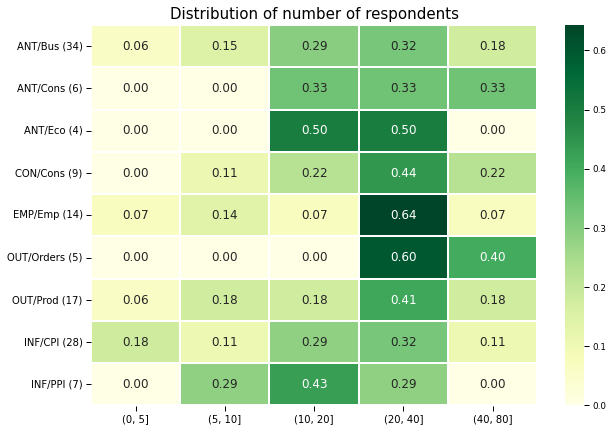

In [9]:
### RUN TO TESTING: SURVEY DATA FORECASTERS NUMBER DISTRIBUTION VISUALIZATION

### Defining observations distribution by bins:
def mean_distribution(df_group, list_bins):
    ser_obs_bins = pd.cut(df_group['Mean_Observations'], bins = list_bins, retbins = False).value_counts(normalize = True)
    return ser_obs_bins

### Forecast data loading:
df_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared)
### Observations numbers summarizing:
df_survey_data = df_cleared.groupby('Index_Name', group_keys = False).apply(lambda df_group: df_group[: 1].droplevel('Release_Date'))[['Type', 'Region']]
df_survey_data['Mean_Observations'] = df_cleared.groupby('Index_Name')['Observations_Number'].mean()
### Bin edge defining:
list_bins = [0, 5, 10, 20, 40, 80]
#### Distribution by type/region:
#df_type_region_distr = df_survey_data.groupby(['Type', 'Region']).apply(mean_distribution).unstack(-1)
#df_type_region_distr.set_index(df_type_region_distr.index.get_level_values(0) + ' | ' + df_type_region_distr.index.get_level_values(1))
#df_type_region_distr.columns.name = 'Mean surveys number for type/region pair'
### Distribution by type only:
df_type_only_distr = df_survey_data.groupby(['Type']).apply(mean_distribution, list_bins).unstack(-1)
#df_type_only_distr.columns.name = 'Mean surveys number distribution for each type'
### Index editing:
df_type_only_distr.set_index(df_type_only_distr.index.values + ' (' + df_survey_data.groupby(['Type'])['Mean_Observations'].count().astype(str) + ')', inplace = True)
df_type_only_distr = pd.concat([df_type_only_distr.iloc[: 5], df_type_only_distr.iloc[7 : ], df_type_only_distr.iloc[5 : 7]], axis = 0)
### Heatmap plotting:
plt.figure(figsize = (10, 7))
sns.set_context('paper', rc = {'font.size': 12, 'axes.titlesize': 15}) 
ax_heat = sns.heatmap(df_type_only_distr, cmap = 'YlGn', annot = True, fmt = '.2f', linewidths = 2.0, linecolor = 'white')
ax_heat.axes.set_title('Distribution of number of respondents')
ax_heat.set_ylabel('')
ax_heat.tick_params(labelsize = 10)
plt.show()

In [10]:
### RUN TO RE-EXPORT DATA: SETTING TICKER/DATA PAIR WEIGHTS

### Forecast data loading:
df_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared)
df_cleared['Observations_Number'] = df_cleared['Observations_Number'].astype(int)
### Resampling to businnes daily frequency without gaps:
df_cleared = df_cleared.unstack('Index_Name').resample('B').asfreq().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Adding rolling mean of obseravtions number:
df_cleared['Rolling_Obs_Number'] = df_cleared['Observations_Number'].unstack('Index_Name').sort_index().rolling(window = int_obs_num_win, min_periods = 1).mean().round(0)\
                                                                    .stack('Index_Name', dropna = False).swaplevel().sort_index()
### Dropping NA values (we need it only to correct rolling mean calculation):
df_weighted = df_cleared.dropna().drop('Observations_Number', axis = 1)
### Setting initial weight by square root of observations number:
df_weighted['Obs_Num_Weight'] = df_weighted.groupby(['Release_Date', 'Region', 'Type'])['Rolling_Obs_Number']\
                                           .transform(lambda ser_group: np.sqrt(ser_group) / np.sqrt(ser_group).sum())
### Extracting existing Date / Type / Region combinations:
ser_region_count = df_weighted.groupby(['Release_Date', 'Type', 'Region'])['Type'].count()
ser_region_count = ser_region_count / ser_region_count
ser_region_count.name = 'Group_Flag'
### Region weights preparing:
ser_region_weight = pd.DataFrame.from_dict(dict_region_weight, orient = 'index').squeeze()
ser_region_weight.name = 'Region_Weight'
### Adding region weights to combinations collection:
df_region_weight = ser_region_count.to_frame().join(ser_region_weight, how = 'left', on = 'Region')
### Region weights normalizing:
df_region_weight['Reg_Norm_Weight'] = df_region_weight.groupby(['Release_Date', 'Type'])['Region_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_region_weight['Reg_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type', 'Region'])
### Adding Growth Index flag:
df_weighted['Growth'] = True
df_weighted.loc[df_weighted['Type'].isin(['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Extracting existing Date / Type combinations:
ser_type_count = df_weighted.groupby(['Release_Date', 'Type'])['Type'].count()
ser_type_count = ser_type_count / ser_type_count
ser_type_count.name = 'Type_Flag'
### FPC weights export:
ser_fpc_weight = pd.read_hdf(str_path_fpc_hdf, key = str_weights_key).stack(dropna = False).swaplevel()
ser_fpc_weight.index.names = ['Type', 'Release_Date']
ser_fpc_weight.name = 'FPC_Weight'
### Adding region weights to combinations collection:
df_type_weight = ser_type_count.to_frame().join(ser_fpc_weight, how = 'left', on = ['Type', 'Release_Date'])
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'FPC_Weight'] = 0.5
### Adding Growth Index flag:
df_type_weight['Growth'] = True
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Type weights normalizing:
df_type_weight['Type_Norm_Weight'] = df_type_weight.groupby(['Release_Date', 'Growth'])['FPC_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Filling dates with empty FPC weights (3 dates filled):
df_type_weight['Type_Norm_Weight'] = df_type_weight['Type_Norm_Weight'].groupby('Type').ffill()
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_type_weight['Type_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type'])
### Ticker weights calculating for each date / ticker pair:
df_weighted['Ticker_Weight'] = df_weighted['Obs_Num_Weight'] * df_weighted['Reg_Norm_Weight'] * df_weighted['Type_Norm_Weight']
### Table saving:
df_weighted[['Release_Value', 'Survey_Median', 'Forecast_Std', 'Rolling_Obs_Number', 'Ticker_Weight', 'Growth']]\
           .to_hdf(str_path_bb_fcast_hdf, key = str_key_weighted, mode = 'a')

In [18]:
### RUN TO TESTING: WEIGHTS VERIFYING

#df_weighted = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
gc.collect()
#ser_test_1 = df_weighted.groupby(['Release_Date', 'Type', 'Region']).apply(lambda df_group: df_group['Obs_Num_Weight'].sum())
#ser_test_2 = df_weighted.groupby(['Release_Date', 'Type']).apply(lambda df_group: (df_group['Obs_Num_Weight'] * df_group['Reg_Norm_Weight']).sum())
#ser_test_3 = df_weighted.groupby(['Release_Date', 'Growth'])\
#                        .apply(lambda df_group: (df_group['Obs_Num_Weight'] * df_group['Reg_Norm_Weight'] * df_group['Type_Norm_Weight']).sum())
#ser_test_4 = df_weighted.groupby(['Release_Date', 'Growth'])['Ticker_Weight'].sum()
#print('Standalone weights test:', ser_test_1.count())
#print('Standalone weights test:', ser_test_1[abs(ser_test_1 - 1.0) > flo_winsorize_tolerance])
#print('Region weights test:', ser_test_2.count())
#print('Region weights test:', ser_test_2[abs(ser_test_2 - 1.0) > flo_winsorize_tolerance])
#print('Type weights test:', ser_test_3.count())
#print('Type weights test:', ser_test_3[abs(ser_test_3 - 1.0) > flo_winsorize_tolerance])
#print('Ticker weights test:', ser_test_4.count())
#print('Ticker weights test:', ser_test_4[abs(ser_test_4 - 1.0) > flo_winsorize_tolerance])

Ticker weights test: 11281
Ticker weights test: Series([], Name: Ticker_Weight, dtype: float64)


In [22]:
### RUN TO RE-EXPORT DATA: ECONOMIC SURPRISE INDEX CONSTRUCTING (SMOOTHED)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    if (len(df_date.index) < int_min_tickers_to_go):
        return np.NaN
    else:
#        ser_date_surprise = (df_date['Release_Value'] - df_date['Survey_Median']) / df_date['Forecast_Std']
        ser_date_surprise = (df_date['Rolling_Diff'] / df_date['Rolling_Std']).clip(list_clip[0], list_clip[1])
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
        return flo_surprise
    
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Dropping zero stdev values:
df_surprise.loc[df_surprise['Forecast_Std'] < flo_winsorize_tolerance, 'Forecast_Std'] = np.NaN
### Resampling to business daily frequency without gaps:
df_surprise = df_surprise.unstack('Index_Name').resample('B').asfreq().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Factors collection:
dict_surprise = {}
### Looping over smoothing options:
for iter_month_num in list_smooth:
    ### Adding rolling mean of stdev:
    df_surprise['Rolling_Std'] = df_surprise['Forecast_Std'].unstack('Index_Name').sort_index()\
                                                            .rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()\
                                                            .stack('Index_Name', dropna = False).swaplevel().sort_index()
    df_surprise['Rolling_Diff'] = (df_surprise['Release_Value'] - df_surprise['Survey_Median']).unstack('Index_Name').sort_index()\
                                                                            .rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()\
                                                                                               .stack('Index_Name', dropna = False).swaplevel().sort_index()
    ### Dropping NA values (we need it only to correct rolling mean calculation):
    df_surprise.dropna(inplace = True)
    ### Data dividing:
    dict_weighted = {}
    dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
    dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
    ### Factors calculating:

    for iter_key in dict_weighted:
        ser_surprise = dict_weighted[iter_key].dropna().groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
        ser_surprise.name = 'Economic Surprise Index (' + iter_key + ')'
        ser_surprise.index.name = 'Date'
        ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = ser_surprise
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_surprise, mode = 'a')

AttributeError: 'AxesSubplot' object has no attribute 'rowNum'

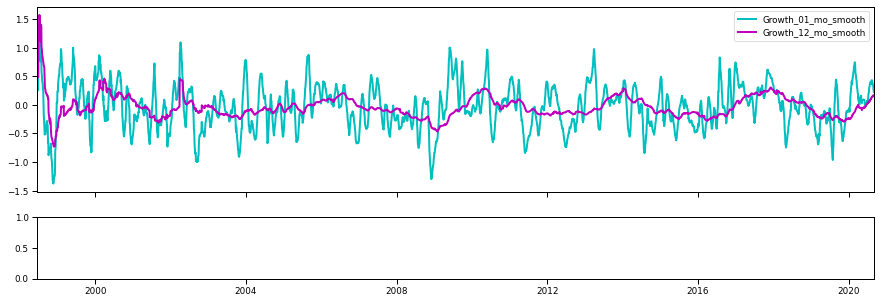

In [23]:
### RUN TO TESTING: ECONOMIC SURPRISE INDEX VISUALIZING (MULTIPLE)

### Global indices loading:
df_global = pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_mom'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_yoy'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_mom'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_yoy')], axis = 1)
### Factors loading:
df_surprise_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_surprise)
#df_surprise_full = pd.concat(dict_surprise, axis = 1).sort_index(axis = 1)
int_iter_len = len(df_surprise_full.columns) // 2
### Factors iterating:
for iter_num in range(2):
    ### Disagreemnt factor extracting:
    df_surprise_iter = df_surprise_full.iloc[:, iter_num * int_iter_len : (iter_num + 1) * int_iter_len].dropna()
    iter_key = df_surprise_iter.columns[0].partition('_')[0]
    ### Main index adding:
    df_main_index_iter = df_global.iloc[:, iter_num * 2 : (iter_num + 1) * 2].loc[df_surprise_iter.index]
    ### Visualizing pattern defining:
    list_style_pattern = ['c-', 'm-', 'b-', 'r-', 'g-', 'y--', 'k-', 'gray']
    ### Plot creating:
    fig_key, ax_key = plt.subplots(2, 1, sharex = True, figsize = (15, 5), gridspec_kw = {'height_ratios': [3, 1]})
    df_surprise_iter.plot(title = 'Economic Surprise Index (' + iter_key + ')', 
                          style = list_style_pattern[: 3], linewidth = 2.0, alpha = 1.0, grid = True, x_compat = True, ax = ax_key[0])
    df_main_index_iter.plot(title = iter_key + ' Index', style = list_style_pattern[3 : 5], linewidth = 2.0, alpha = 0.75, grid = True, x_compat = True, ax = ax_key[1])
    ### Recession periods adding:
    df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
    ### Market down periods adding:
    df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)    
    for ax_iter in ax_key:
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            ax_iter.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * (iter_num + 1) + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            ax_iter.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * (iter_num + 1) + 'MSCI market down periods')         
            
        ax_iter.xaxis.set_major_locator(mdates.YearLocator(base = 5))
        ax_iter.xaxis.set_minor_locator(mdates.YearLocator(base = 1))
        ax_iter.legend(loc = 'upper left')
    ### Plot drawing:
    plt.show()

In [ ]:
### RUN TO RE-EXPORT DATA: SURVEY DISAGREEMENT INDEX CONSTRUCTING

### Defining index vector average calculator:
def release_date_stdev(df_date, int_min_tickers_to_go):
    if (len(df_date.index)  < int_min_tickers_to_go):        
        return np.NaN
    else:
        ser_date_stdev = (df_date['Rolling_Std_Short']  / df_date['Rolling_Std_Long']).clip(0, list_clip[1])
        flo_stdev = (ser_date_stdev * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
        return flo_stdev
    
### Economic surprise data loading:
df_stdev = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Resampling to business daily frequency without gaps:
df_stdev = df_stdev.unstack('Index_Name').resample('B').asfreq().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Factors calculating:
dict_stdev = {}
### Looping over smoothing options:
for iter_month_num in list_smooth:
    ### Adding rolling mean of stdev:
    df_stdev['Rolling_Std_Short'] = df_stdev['Forecast_Std'].unstack('Index_Name').sort_index().rolling(int_bus_month * iter_month_num, min_periods = int_bus_min)\
                                                           .mean().stack('Index_Name', dropna = False).swaplevel().sort_index()
    df_stdev['Rolling_Std_Long'] = df_stdev['Forecast_Std'].unstack('Index_Name').sort_index().rolling(window = int_disagreement_max, min_periods = int_disagreement_min)\
                                                           .mean().stack('Index_Name', dropna = False).swaplevel().sort_index()
    ### Dropping NA values (we need it only to correct rolling mean calculation):
    df_stdev.dropna(inplace = True)
    ### Data dividing:
    dict_weighted = {}
    dict_weighted['Growth'] = df_stdev[df_stdev['Growth'] == True]
    dict_weighted['Inflation'] = df_stdev[df_stdev['Growth'] == False]
    ### Factors calculating:
    for iter_key in dict_weighted:
        ### Average stdev caclulation:
        ser_stdev = dict_weighted[iter_key].dropna().groupby('Release_Date').apply(release_date_stdev, int_min_tickers_to_go)
        ser_stdev.name = 'Survey Disagreement Index (' + iter_key + ')'
        ser_stdev.index.name = 'Date'
        ser_stdev = ser_stdev.reindex(pd.date_range(ser_stdev.index.min(), ser_stdev.index.max(), freq = 'B')).ffill()
        dict_stdev[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = ser_stdev
### Factor saving:
#pd.concat(dict_stdev, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_disagreement, mode = 'a')    

In [ ]:
### RUN TO TESTING: SURVEY DISAGREEMENT INDEX VISUALIZING (REAL SIZE)

### Global indices loading:
df_global = pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_mom'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_yoy'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_mom'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_yoy')], axis = 1)
### Factors loading:
df_stdev_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_disagreement)
#df_stdev_full = pd.concat(dict_stdev, axis = 1).sort_index(axis = 1)
int_iter_len = len(df_stdev_full.columns) // 2
### Factors iterating:
for iter_num in range(2):
    ### Disagreemnt factor extracting:
    df_stdev_iter = df_stdev_full.iloc[:, iter_num * int_iter_len : (iter_num + 1) * int_iter_len].dropna()
    iter_key = df_stdev_iter.columns[0].partition('_')[0]
    ### Main index adding:
    df_main_index_iter = df_global.iloc[:, iter_num * 2 : (iter_num + 1) * 2].loc[df_stdev_iter.index]
    ### Visualizing pattern defining:
    list_style_pattern = ['c-', 'm-', 'b-', 'r-', 'g-', 'y--', 'k-', 'gray']
    ### Plot creating:
    fig_key, ax_key = plt.subplots(2, 1, sharex = True, figsize = (15, 5), gridspec_kw = {'height_ratios': [3, 1]})
    df_stdev_iter.plot(title = 'Survey Disagreement Index (' + iter_key + ')', style = list_style_pattern[: 3], linewidth = 2.0, alpha = 1.0, grid = True, x_compat = True, 
                       ax = ax_key[0])
    df_main_index_iter.plot(title = iter_key + ' Index', style = list_style_pattern[3 : 5], linewidth = 2.0, alpha = 0.75, grid = True, x_compat = True, ax = ax_key[1])
    ### Recession periods adding:
    df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
    ### Market down periods adding:
    df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)    
    for ax_iter in ax_key:
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            ax_iter.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * (iter_num + 1) + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            ax_iter.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * (iter_num + 1) + 'MSCI market down periods')         
            
        ax_iter.xaxis.set_major_locator(mdates.YearLocator(base = 5))
        ax_iter.xaxis.set_minor_locator(mdates.YearLocator(base = 1))
        ax_iter.legend(loc = 'upper left')
    ### Plot drawing:
    plt.show()

In [ ]:
### RUN TO TESTING: ALTERNATIVE INDICES VISUALIZING

### Global indices loading:
df_global = pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_mom'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_yoy'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_mom'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_yoy')], axis = 1)
### Factors loading:
df_surprise_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_surprise)
### Factors loading:
df_stdev_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_disagreement)
### Visualizing pattern defining:
list_style_pattern = ['c-', 'm-', 'b-', 'r-', 'g-', 'y--', 'k-', 'gray']
### Looping over index types:
for iter_key in range(2):
    ### Extracting data for particular global index
    df_surprise_iter = df_surprise_full.iloc[:, (iter_key * 2) : ((iter_key + 1) * 2)].copy()        
    df_stdev_iter = df_stdev_full.iloc[:, (iter_key * 2) : ((iter_key + 1) * 2)].copy()
    df_global_iter = df_global.iloc[:, (iter_key * 2) : ((iter_key + 1) * 2)].copy()
    str_name = df_surprise_iter.columns[0].partition('_')[0]
    ### Looping over smoothing ways:
    for iter_num, iter_smooth in enumerate(['Monthly', 'Annual']):
        ### Extracting data for particular smoothing way:
        df_data_iter = pd.concat([df_global_iter.iloc[:, iter_num], df_surprise_iter.iloc[:, iter_num], df_stdev_iter.iloc[:, iter_num]], axis = 1)
        df_data_iter = df_data_iter.dropna(subset = [df_data_iter.columns[1]])
        df_data_iter.columns = [str_name + ' Index ' + df_data_iter.columns[0].partition(' ')[-1], 
                                'Economic Surprise Index (' + str_name + ')',
                                'Survey Disagreement Index (' + str_name + ')']
        ### Plot creating:
        fig_key, ax_key = plt.subplots(2, 1, sharex = True, figsize = (15, 5), gridspec_kw = {'height_ratios': [3, 2]})
        ### Global index plotting:
        df_data_iter.iloc[: , 0].plot(title = df_data_iter.columns[0] + ' with ' + iter_smooth + ' smoothed Forecast Indices', style = list_style_pattern[0], 
                                      linewidth = 2.0, alpha = 1.0, grid = True, x_compat = True, ax = ax_key[0], ylim = [-4, 4])
        ### Economic Surprise plotting:
        ax_twinx = ax_key[0].twinx()
        df_data_iter.iloc[: , 1].plot(style = list_style_pattern[1], linewidth = 2.0, alpha = 1.0, grid = True, x_compat = True, ax = ax_twinx, ylim = [-2, 2])        
        ax_key[0].set_ylabel(str_name + ' Index')        
        ax_twinx.set_ylabel('Economic surprise') 
        ### Survey disagreement plotting:
        df_data_iter.iloc[: , 2].plot(style = list_style_pattern[2], linewidth = 2.0, alpha = 0.75,grid = True, x_compat = True, ax = ax_key[1], ylim = [0.5, 2])
        ### Recession periods adding:
        df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
        ### Market down periods adding:
        df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)  
        ### NBER and MSCI backgrounds adding:
        for ax_iter in ax_twinx, ax_key[1]:
            for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
                ax_iter.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                                label = '_' * iter_num + 'NBER recession periods')
            for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
                ax_iter.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                                label = '_' * iter_num + 'MSCI market down periods')         

            ax_iter.xaxis.set_major_locator(mdates.YearLocator(base = 5))
            ax_iter.xaxis.set_minor_locator(mdates.YearLocator(base = 1))        
        ### First subplot legend drawing:
        lines_0, labels_0 = ax_key[0].get_legend_handles_labels()
        lines_twinx, labels_twinx = ax_twinx.get_legend_handles_labels()
        lines = lines_0 + lines_twinx
        labels = labels_0 + labels_twinx
        ax_key[0].legend().remove()
        ax_twinx.legend(lines, labels, loc = 'lower left')
        ### Second subplot legend drawing:        
        ax_key[1].legend(loc = 'lower left')        
        ### Plot drawing:
        plt.show()        
#        break
#    break

In [ ]:
### RUN TO TESTING: FORECAST INDICES - NBER RECESSION PERIODS STATS

### Factors loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_surprise)
df_stdev = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_disagreement)
df_factor = pd.concat([df_surprise, df_stdev], axis = 1, keys = ['Economic Surprise Index', 'Survey Disagreement Index'])
### Recession periods loading:
df_nber_periods = pd.read_hdf(str_path_nber_hdf, str_nber_periods_key)
### Adding out-of-recession periods:
df_nber_periods['Beg_Date_shifted'] = df_nber_periods['Beg_Date'].shift(-1).fillna(datetime_end)
### Average collections:
dict_level_period_mean = {}
dict_level_not_mean = {}
dict_level_before_mean = {}
dict_level_after_mean = {}
### NBER Recession periods looping:
for iter_period in df_nber_periods.itertuples():
    iter_index = iter_period.Index
    date_beg_period = iter_period.Beg_Date
    date_end_period = iter_period.End_Date
    date_shifted = iter_period.Beg_Date_shifted
    if (max(datetime_start, df_surprise.index[0]) < date_end_period):
        ### Recession periods determination:
        idx_period_iter = pd.date_range(start = date_beg_period, end = date_end_period, freq = 'B')
        idx_not_iter = pd.date_range(start = date_end_period, end = date_shifted, freq = 'B')                
        idx_before_iter = pd.date_range(start = date_beg_period - pd.DateOffset(months = 12), end = date_beg_period, freq = 'B')
        idx_after_iter = pd.date_range(start = date_end_period, end = date_end_period + pd.DateOffset(months = 12), freq = 'B')
        ### Mean values determination:
        dict_level_before_mean[iter_index] = df_factor.loc[idx_before_iter, All].mean()
        dict_level_not_mean[iter_index] = df_factor.loc[idx_not_iter, All].mean()                
        dict_level_period_mean[iter_index] = df_factor.loc[idx_period_iter, All].mean()
        dict_level_after_mean[iter_index] = df_factor.loc[idx_after_iter, All].mean()
### Average of periods mean:
ser_level_period_mean = pd.DataFrame(dict_level_period_mean).mean(axis = 1)
ser_level_period_mean.name = 'Level: During recession periods mean'
ser_level_not_mean = pd.DataFrame(dict_level_not_mean).mean(axis = 1)
ser_level_not_mean.name = 'Level: non-recession periods mean'
ser_level_before_mean = pd.DataFrame(dict_level_before_mean).mean(axis = 1)
ser_level_before_mean.name = 'Level: 12-mo before recession periods mean'
ser_level_after_mean = pd.DataFrame(dict_level_after_mean).mean(axis = 1)
ser_level_after_mean.name = 'Level: 12-mo after recession periods mean'
### Table aggregating:
df_nber_mean = pd.concat([ser_level_period_mean, ser_level_not_mean, ser_level_before_mean, ser_level_after_mean], axis = 1).transpose()
df_nber_mean.name = 'NBER Recession periods stats'
#print(df_nber_mean.name, ':')
#display(df_nber_mean)
#df_nber_mean.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

In [ ]:
### RUN TO TESTING: FORECAST INDICES - MSCI MARKET DOWN PERIODS STATS

### Factors loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_surprise)
df_stdev = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_disagreement)
df_factor = pd.concat([df_surprise, df_stdev], axis = 1, keys = ['Economic Surprise Index', 'Survey Disagreement Index'])
### Recession periods loading:
df_msci_periods = pd.read_hdf(str_path_msci_hdf, str_msci_market_down_key)
### Adding out-of-recession periods:
df_msci_periods['Beg_Date_shifted'] = df_msci_periods['Beg_Date'].shift(-1).fillna(datetime_end)
### Average collections:
dict_level_period_mean = {}
dict_level_not_mean = {}
dict_level_before_mean = {}
dict_level_after_mean = {}
### NBER Recession periods looping:
for iter_period in df_msci_periods.itertuples():
    iter_index = iter_period.Index
    date_beg_period = iter_period.Beg_Date
    date_end_period = iter_period.End_Date
    date_shifted = iter_period.Beg_Date_shifted
    if (max(datetime_start, df_surprise.index[0]) < date_end_period):
        ### Recession periods determination:
        idx_period_iter = pd.date_range(start = date_beg_period, end = date_end_period, freq = 'B')
        idx_not_iter = pd.date_range(start = date_end_period, end = date_shifted, freq = 'B')                
        idx_before_iter = pd.date_range(start = date_beg_period - pd.DateOffset(months = 12), end = date_beg_period, freq = 'B')
        idx_after_iter = pd.date_range(start = date_end_period, end = date_end_period + pd.DateOffset(months = 12), freq = 'B')
        ### Mean values determination:
        dict_level_before_mean[iter_index] = df_factor.loc[idx_before_iter, All].mean()
        dict_level_not_mean[iter_index] = df_factor.loc[idx_not_iter, All].mean()                
        dict_level_period_mean[iter_index] = df_factor.loc[idx_period_iter, All].mean()
        dict_level_after_mean[iter_index] = df_factor.loc[idx_after_iter, All].mean()
### Average of periods mean:
ser_level_period_mean = pd.DataFrame(dict_level_period_mean).mean(axis = 1)
ser_level_period_mean.name = 'Level: During recession periods mean'
ser_level_not_mean = pd.DataFrame(dict_level_not_mean).mean(axis = 1)
ser_level_not_mean.name = 'Level: non-recession periods mean'
ser_level_before_mean = pd.DataFrame(dict_level_before_mean).mean(axis = 1)
ser_level_before_mean.name = 'Level: 12-mo before recession periods mean'
ser_level_after_mean = pd.DataFrame(dict_level_after_mean).mean(axis = 1)
ser_level_after_mean.name = 'Level: 12-mo after recession periods mean'
### Table aggregating:
df_msci_mean = pd.concat([ser_level_period_mean, ser_level_not_mean, ser_level_before_mean, ser_level_after_mean], axis = 1).transpose()
df_msci_mean.name = 'MSCI Market Down periods stats'
#print(df_msci_mean.name, ':')
#display(df_msci_mean)
#df_msci_mean.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

In [ ]:
### RUN TO TESTING: FORECAST INDICES SAVING

### Factors loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_surprise)
df_stdev = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_disagreement)
df_factor = pd.concat([df_surprise, df_stdev], axis = 1, keys = ['Economic Surprise Index', 'Survey Disagreement Index'])
df_factor.to_excel('Data_Files/Test_Files/Forecast_Factors.xlsx', merge_cells = False)

In [ ]:
### RUN TO TESTING: ECONOMIC SURPRISE INDEX CONSTRUCTING (SIMPLE AVERAGE)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    if (len(df_date.index) < int_min_tickers_to_go):
        return np.NaN
    else:
#        ser_date_surprise = (df_date['Release_Value'] - df_date['Survey_Median']) / df_date['Forecast_Std']
        ser_date_surprise = (df_date['Rolling_Diff'] / df_date['Rolling_Std']).clip(list_clip[0], list_clip[1])
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
        return flo_surprise
    
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Dropping zero stdev values:
df_surprise.loc[df_surprise['Forecast_Std'] < flo_winsorize_tolerance, 'Forecast_Std'] = np.NaN
### Resampling to business daily frequency without gaps:
df_surprise = df_surprise.unstack('Index_Name').resample('B').asfreq().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Factors collection:
dict_surprise = {}
### Looping over smoothing options:
for iter_month_num in list_smooth:
    ### Adding rolling mean of stdev:
    df_surprise['Rolling_Std'] = df_surprise['Forecast_Std'].unstack('Index_Name').sort_index()\
                                                            .rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()\
                                                            .stack('Index_Name', dropna = False).swaplevel().sort_index()
    df_surprise['Rolling_Diff'] = (df_surprise['Release_Value'] - df_surprise['Survey_Median']).unstack('Index_Name').sort_index()\
                                                                            .rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()\
                                                                                               .stack('Index_Name', dropna = False).swaplevel().sort_index()
    ### Dropping NA values (we need it only to correct rolling mean calculation):
    df_surprise.dropna(inplace = True)
    df_surprise['Ticker_Weight'] = 1.0
    ### Data dividing:
    dict_weighted = {}
    dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
    dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
    ### Factors calculating:

    for iter_key in dict_weighted:
        ser_surprise = dict_weighted[iter_key].dropna().groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
        ser_surprise.name = 'Economic Surprise Index (' + iter_key + ')'
        ser_surprise.index.name = 'Date'
        ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = ser_surprise
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_surprise_simple, mode = 'a') 

In [ ]:
### RUN TO TESTING: SURVEY DISAGREEMENT INDEX CONSTRUCTING (SIMPLE AVERAGE)

### Defining index vector average calculator:
def release_date_stdev(df_date, int_min_tickers_to_go):
    if (len(df_date.index)  < int_min_tickers_to_go):        
        return np.NaN
    else:
        ser_date_stdev = (df_date['Rolling_Std_Short']  / df_date['Rolling_Std_Long']).clip(0, list_clip[1])
        flo_stdev = (ser_date_stdev * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
        return flo_stdev
    
### Economic surprise data loading:
df_stdev = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Resampling to business daily frequency without gaps:
df_stdev = df_stdev.unstack('Index_Name').resample('B').asfreq().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Factors calculating:
dict_stdev = {}
### Looping over smoothing options:
for iter_month_num in list_smooth:
    ### Adding rolling mean of stdev:
    df_stdev['Rolling_Std_Short'] = df_stdev['Forecast_Std'].unstack('Index_Name').sort_index().rolling(int_bus_month * iter_month_num, min_periods = int_bus_min)\
                                                           .mean().stack('Index_Name', dropna = False).swaplevel().sort_index()
    df_stdev['Rolling_Std_Long'] = df_stdev['Forecast_Std'].unstack('Index_Name').sort_index().rolling(window = int_disagreement_max, min_periods = int_disagreement_min)\
                                                           .mean().stack('Index_Name', dropna = False).swaplevel().sort_index()
    ### Dropping NA values (we need it only to correct rolling mean calculation):
    df_stdev.dropna(inplace = True)
    df_stdev['Ticker_Weight'] = 1.0
    ### Data dividing:
    dict_weighted = {}
    dict_weighted['Growth'] = df_stdev[df_stdev['Growth'] == True]
    dict_weighted['Inflation'] = df_stdev[df_stdev['Growth'] == False]
    ### Factors calculating:
    for iter_key in dict_weighted:
        ### Average stdev caclulation:
        ser_stdev = dict_weighted[iter_key].dropna().groupby('Release_Date').apply(release_date_stdev, int_min_tickers_to_go)
        ser_stdev.name = 'Survey Disagreement Index (' + iter_key + ')'
        ser_stdev.index.name = 'Date'
        ser_stdev = ser_stdev.reindex(pd.date_range(ser_stdev.index.min(), ser_stdev.index.max(), freq = 'B')).ffill()
        dict_stdev[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = ser_stdev
### Factor saving:
pd.concat(dict_stdev, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_disagreement_simple, mode = 'a')    

In [ ]:
### RUN TO TESTING: CONSOLIDATION METHODS COMPARING

### Alternative results loading:
df_surprise_weighted = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_surprise)
df_surprise_simple = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_surprise_simple)
df_stdev_weighted = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_disagreement)
df_stdev_simple = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_disagreement_simple)
### Column-wise correlation performing:
df_corrwith = pd.DataFrame()
df_corrwith['Economic Surprise'] = df_surprise_simple.corrwith(df_surprise_weighted)
df_corrwith['Survey Disagreement'] = df_stdev_simple.corrwith(df_stdev_weighted)
df_corrwith
df_corrwith.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

In [ ]:
### TEMP

gc.collect()